**This notebook implements the same model that appears under [`vlasov_ampere.ipynb`](https://github.com/Classiq/classiq-library/blob/main/applications/plasma/vlasov_ampere/vlasov_ampere.ipynb) example, using qiskit. This is the code used to collect the benchmarking data in [the paper](https://arxiv.org/abs/2507.22257)**.

In particular, it contains: Definition of a qiskit code for the block-encoding, verification of the block-encoding functionality, and definition of QSVT step with qiskit, operating on the block-encoding unitary.

The results were obtained using Qiskit version 2.1.1. 

In [1]:
!pip install -qq  qiskit==2.1.1

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library.standard_gates import XGate
from qiskit.synthesis import synth_qft_full
from sympy import fwht

## Adding inplace adder and assign_amplitudes with Qiskit

These are missing in Qiskit library.

In [3]:
# Creating an inplace adder


class DraperQFTAdderConstant(QuantumCircuit):
    def __init__(
        self, num_state_qubits: int, constant: int, name: str = "DraperQFTAdderConst"
    ) -> None:
        # Create the quantum register
        qr_a = QuantumRegister(num_state_qubits, name="a")
        super().__init__(qr_a, name=name)

        # Apply the QFT
        self.append(synth_qft_full(num_state_qubits, do_swaps=False).to_gate(), qr_a)

        # Add the constant by applying controlled rotations
        for qubit in range(num_state_qubits):
            angle = (constant % (2 ** (qubit + 1))) * np.pi / (2**qubit)
            self.p(angle, qr_a[qubit])

        # Apply the inverse QFT
        self.append(
            synth_qft_full(num_state_qubits, do_swaps=False).inverse().to_gate(), qr_a
        )

In [4]:
# Creating assign amplitudes


def get_graycode(size: int, i: int) -> int:
    if i == 2**size:
        return get_graycode(size, 0)
    return i ^ (i >> 1)


def get_controller(size: int, i: int) -> int:
    return (get_graycode(size, i) ^ get_graycode(size, i + 1)).bit_length() - 1


def get_graycode_angles_wh(size, angles):
    transformed_angles = fwht(np.array(angles) / 2**size)
    return [transformed_angles[get_graycode(size, j)] for j in range(2**size)]


def assign_amplitudes_qs(amps, x, ind):
    qc = QuantumCircuit(x, ind, name="assign amplitudes")
    size = len(amps).bit_length() - 1
    angles = 2 * np.arcsin(amps)
    gray_code_angles = np.array(get_graycode_angles_wh(size, angles)).astype(float)
    gray_code_controllers = [get_controller(size, i) for i in range(2**size)]

    for i in range(2**size):
        qc.ry(gray_code_angles[i], ind)
        qc.cx(x[gray_code_controllers[i]], ind)

    return qc.to_gate()

## Setting problem parameters

In [5]:
# plasma parameters
Temperature = 1
N = 1  # simulate homogenous plasma - n(x) = 1

# source parameters
DS = 3
X_0 = 50
W_0 = 0.8

# grid  parameters
X_MIN = 0
X_MAX = 100

V_MIN = -4
V_MAX = 4

N_X = 3
N_V = 3

DX = (X_MAX - X_MIN) / (2**N_X - 1)
DV = (V_MAX - V_MIN) / (2**N_V - 1)

## Functions for getting quantum circuits ("gates") to construct the block encoding

### Circuits for the Advective part

In [6]:
BC_VALUES = 0.5 * np.array([-3, 3, -1, 0])
BC_NORM = np.linalg.norm(BC_VALUES)
BC_VALUES = BC_VALUES / BC_NORM
lcu_angle = 2 * np.arccos(np.sqrt(BC_NORM / (1 + BC_NORM)))

In [7]:
def get_derivative_dirichlet_be(x, flag, lcu):
    qc = QuantumCircuit(x, flag, lcu, name="derivative_dirichlet_be")
    qc.h(lcu[0])
    qc.z(lcu[0])
    qc.append(
        DraperQFTAdderConstant(num_state_qubits=len(x) + 1, constant=-1)
        .to_gate()
        .control(1, ctrl_state=0),
        [lcu] + x[:] + [flag],
    )
    qc.append(
        DraperQFTAdderConstant(num_state_qubits=len(x) + 1, constant=1)
        .to_gate()
        .control(1, ctrl_state=1),
        [lcu] + x[:] + [flag],
    )
    qc.h(lcu[0])

    return qc.to_gate()


def get_derivative_boundary_min_be(x, flag):
    qc = QuantumCircuit(x, flag, name="derivative_boundary_min_be")
    qc.append(StatePreparation(BC_VALUES).inverse(), x[0:2])
    qc.append(XGate().control(len(x), ctrl_state=0), x[:] + [flag])
    qc.x(flag)

    return qc.to_gate()


def get_derivative_boundary_max_be(x, flag):
    qc = QuantumCircuit(x, flag, name="derivative_boundary_max_be")
    qc.x(x)
    qc.ry(2 * np.pi, flag)
    qc.append(get_derivative_boundary_min_be(x, flag), x[:] + [flag])
    qc.x(x)

    return qc.to_gate()


def get_derivative_boundaries_be(x, flag):
    qc_start = get_derivative_boundary_min_be(x[0:-1], flag)
    qc_end = get_derivative_boundary_max_be(x[0:-1], flag)
    qc = QuantumCircuit(x, flag, name="derivative_boundaries_be")
    qc.append(qc_start.control(1, ctrl_state=0), [x[-1]] + x[0:-1] + [flag])
    qc.append(qc_end.control(1, ctrl_state=1), [x[-1]] + x[0:-1] + [flag])

    return qc.to_gate()


def get_derivative_be(x, flag, lcu1, lcu2):
    qc = QuantumCircuit(x, flag, lcu1, lcu2, name="derivative_be")
    qc.ry(lcu_angle, lcu1)
    qc.append(
        get_derivative_dirichlet_be(x, flag, lcu2).control(1, ctrl_state=1),
        [lcu1] + x[:] + [flag] + [lcu2],
    )
    qc.append(
        get_derivative_boundaries_be(x, flag).control(1, ctrl_state=0),
        [lcu1] + x[:] + [flag],
    )
    qc.ry(-lcu_angle, lcu1)

    return qc.to_gate()


def get_be_zeta(x, v, flag):
    temp1 = QuantumRegister(1, "temp1")
    temp2 = QuantumRegister(1, "temp2")

    qc = QuantumCircuit(x, v, flag, temp1, temp2, name="zeta_bc matrix")
    qc.append(XGate().control(len(x), ctrl_state=2 ** len(x) - 1), x[:] + [temp1])
    qc.cx(v[-1], temp2)
    qc.ccx(temp1, temp2, flag)
    qc.cx(v[-1], temp2)
    qc.append(XGate().control(len(x), ctrl_state=2 ** len(x) - 1), x[:] + [temp1])
    qc.append(XGate().control(len(x), ctrl_state=0), x[:] + [temp1])
    qc.append(XGate().control(1, ctrl_state=0), [v[-1]] + [temp2])
    qc.ccx(temp1, temp2, flag)
    qc.append(XGate().control(1, ctrl_state=0), [v[-1]] + [temp2])
    qc.append(XGate().control(len(x), ctrl_state=0), x[:] + [temp1])

    return qc.to_gate()


def get_v_be(v, ind):
    qc = QuantumCircuit(v, ind, name="v dot matrix")
    N_V = len(v)
    amplitudes = np.linspace(-1, 1 - 2 ** (-N_V + 1), 2**N_V)
    amplitudes = np.roll(amplitudes, len(amplitudes) // 2)  # adjust to signed number
    qc.append(assign_amplitudes_qs(amplitudes, v, ind), v[:] + [ind])
    qc.x(ind)

    return qc.to_gate()


# The upper left matrix: 6 block terms, 2 aux
def get_advective_be(x, v, e, flags):
    temps = QuantumRegister(2, "temps")
    qc = QuantumCircuit(x, v, e, flags, temps, name="Full v grad_x")
    qc.append(
        get_derivative_be(x, [flags[0]], [flags[1]], [flags[2]]), x[:] + flags[0:3]
    )
    qc.append(get_v_be(v, [flags[3]]), v[:] + [flags[3]])
    qc.append(get_be_zeta(x, v, [flags[4]]), x[:] + v[:] + [flags[4]] + temps[:])
    qc.cx(e, flags[5])

    return qc.to_gate()

### Circuits for off-diagonal terms

In [8]:
v_amplitudes = np.linspace(-1, 1 - 2 ** (-N_V + 1), 2**N_V) * V_MAX
v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)  # adjust to signed number
v_H_amplitudes = (
    v_amplitudes
    * np.exp(-(v_amplitudes**2) / (2 * Temperature))
    / (np.sqrt(2 * np.pi * Temperature))
)


def get_force_term_be(v, flag, v_H_amplitudes):
    qc = QuantumCircuit(v, flag, name="force_term")
    qc.append(XGate().control(len(v), ctrl_state=0), v[:] + [flag])
    qc.x(flag)
    qc.append(StatePreparation(-v_H_amplitudes / np.linalg.norm(v_H_amplitudes)), v[:])

    return qc.to_gate()


def get_current_term_be(v, flag, v_amplitudes):
    qc = QuantumCircuit(v, flag, name="current_term")
    qc.append(
        StatePreparation(v_amplitudes / np.linalg.norm(v_amplitudes)).inverse(), v[:]
    )
    qc.append(XGate().control(len(v), ctrl_state=0), v[:] + [flag])
    qc.x(flag)

    return qc.to_gate()


def get_equalize_amplitude(e, ind, ratio):
    qc = QuantumCircuit(e, ind, name="equalize_amplitude")
    amplitudes = np.array([ratio, 1])
    amplitudes /= max(amplitudes)
    qc.append(assign_amplitudes_qs(amplitudes, e, ind), e[:] + [ind])
    qc.x(ind)

    return qc.to_gate()


def get_off_diag_be(e, v, flag, ind, v_H_amplitudes, v_amplitudes, ratio):
    qc = QuantumCircuit(e, v, flag, ind, name="off diagonal")
    qc.x(e)
    qc.append(
        get_force_term_be(v, flag, v_H_amplitudes).control(1, ctrl_state=0),
        [e] + v[:] + [flag],
    )
    qc.append(
        get_current_term_be(v, flag, v_amplitudes).control(1, ctrl_state=1),
        [e] + v[:] + [flag],
    )
    qc.append(get_equalize_amplitude(e, ind, ratio), [e] + [ind])

    return qc.to_gate()

## Block-encoding of the full matrix

In [9]:
DERIVATIVE_TERM_FACTOR = 2 * (1 + BC_NORM)
ADVECTIVE_TERM_FACTOR = DERIVATIVE_TERM_FACTOR * (V_MAX / (2 * DX))

FORCE_TERM_FACTOR = np.linalg.norm(v_H_amplitudes)
CURRENT_TERM_FACTOR = np.linalg.norm(v_amplitudes) * DV

OFF_DIAG_FACTOR = max(FORCE_TERM_FACTOR, CURRENT_TERM_FACTOR)

In [10]:
# Defining a function for 1j factor


def get_phase():
    q = QuantumRegister(1, "q")
    qc = QuantumCircuit(q, name="1j phase")
    qc.p(np.pi, q)
    qc.rz(-np.pi, q)

    return qc.to_gate()

In [11]:
data_size = N_V + N_X + 1
data_qs = QuantumRegister(data_size, "data_qs")
block_qs = QuantumRegister(2 + 6 + 2, "block_qs")

lcu_amps = np.sqrt(
    np.array([ADVECTIVE_TERM_FACTOR, OFF_DIAG_FACTOR, W_0, 0]).astype("float")
)
lcu_amps /= np.linalg.norm(lcu_amps)


qc = QuantumCircuit(data_qs, block_qs)

qc.append(StatePreparation(lcu_amps), block_qs[0:2])
qc.append(
    get_advective_be(
        data_qs[N_V : data_size - 1],
        data_qs[0:N_V],
        [data_qs[data_size - 1]],
        block_qs[0 + 2 : 6 + 2],
    ).control(2, ctrl_state=0),
    block_qs[0:2]
    + data_qs[N_V : data_size - 1]
    + data_qs[0:N_V]
    + [data_qs[data_size - 1]]
    + block_qs[2:],
)
qc.append(
    get_off_diag_be(
        [data_qs[data_size - 1]],
        data_qs[0:N_V],
        [block_qs[0 + 2]],
        [block_qs[3 + 2]],
        v_H_amplitudes,
        v_amplitudes,
        FORCE_TERM_FACTOR / CURRENT_TERM_FACTOR,
    ).control(2, ctrl_state=1),
    block_qs[0:2]
    + [data_qs[data_size - 1]]
    + data_qs[0:N_V]
    + [block_qs[0 + 2]]
    + [block_qs[3 + 2]],
)
qc.append(get_phase().control(2, ctrl_state=2), block_qs[0:2] + [block_qs[2]])
inv_amps = lcu_amps
inv_amps[0] *= -1  # minus sign for the advective term
qc.append(StatePreparation(inv_amps).inverse(), block_qs[0:2])

be_qc = qc.to_gate()

In [12]:
# Scaling factor
BE_NORM_FACTOR = ADVECTIVE_TERM_FACTOR + OFF_DIAG_FACTOR + W_0

## Verification

For the given problem size, `N_X, N_V= 3, 3`, we construct the classical matrix $A+i\omega$ that we block-encoded via a quantum circuit $U_{A+i\omega}$. Then for some random initial state $|\psi\rangle$ we verify that indeed:
$$
U_{A+i\omega} |\psi\rangle |0\rangle_{\rm block} = (A+i\omega)|\psi\rangle|0\rangle_{\rm block}+{\rm garbage}
$$

### Classical matrix

In [13]:
import numpy as np


def get_advective_mat(nx, nv, dx, v_max, cyclic=False):
    dx_mat = np.diag(np.ones(2**nx - 1), k=1) - np.diag(np.ones(2**nx - 1), k=-1)
    boundary = np.pad([-3, 4, -1], (0, dx_mat.shape[1] - 3))
    dx_mat[0, :] = boundary
    dx_mat[-1, :] = -np.flip(boundary)

    v_amplitudes = np.linspace(-1, 1 - 2 ** (-nv + 1), 2**nv) * v_max
    v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)

    x_values = np.arange(2**nx)
    max_x = 2**nx - 1
    xi = (
        1
        - np.kron(x_values == 0, v_amplitudes > 0)
        - np.kron(x_values == max_x, v_amplitudes <= 0)
    )

    advective = np.kron(dx_mat / (2 * dx), np.diag(v_amplitudes))
    advective[xi == 0] = 0

    return advective


def get_off_diag_mat(nx, nv, dv, v_max, temp):
    v_amplitudes = np.linspace(-1, 1 - 2 ** (-nv + 1), 2**nv) * v_max
    v_amplitudes = np.roll(v_amplitudes, len(v_amplitudes) // 2)
    v_H_amplitudes = (
        v_amplitudes
        * np.exp(-(v_amplitudes**2) / (2 * temp))
        / (np.sqrt(2 * np.pi * temp))
    )

    vec_col = v_H_amplitudes
    vec_row = v_amplitudes * dv

    n = len(vec_col)
    dim_x = 2**nx
    dim_v = 2**nv
    size = dim_x * dim_v

    A = np.zeros((size, size))
    B = np.zeros((size, size))
    for i in range(dim_x):
        A[i * dim_v : (i + 1) * dim_v, i * dim_v] = vec_col
        B[i * dim_v, i * dim_v : (i + 1) * dim_v] = vec_row

    # Compose off-diagonal block matrix
    top = np.hstack((np.zeros_like(A), -A))
    bottom = np.hstack((B, np.zeros_like(B)))
    off_diag = np.vstack((top, bottom))
    return off_diag


def get_block_encoding(nx, nv, v_max, x_max, w0, temp):
    dx = x_max / (2**nx - 1)
    dv = (2 * v_max) / (2**nv - 1)

    mat_size = 2 ** (nx + nv + 1)
    advective = get_advective_mat(nx, nv, dx, v_max)
    off_diag = get_off_diag_mat(nx, nv, dv, v_max, temp)

    return 1j * w0 * np.eye(mat_size) - np.kron(np.diag([1, 0]), advective) + off_diag

In [14]:
mat_cl = get_block_encoding(N_X, N_V, V_MAX, X_MAX, W_0, Temperature)

In [15]:
# Random initial state
init_data = np.random.rand(2**7)
init_data /= np.linalg.norm(init_data)

In [16]:
block_qs = QuantumRegister(10, "block_qs")
data_qs = QuantumRegister(data_size, "data_qs")

qc_test = QuantumCircuit(data_qs, block_qs)
qc_test.append(StatePreparation(init_data), data_qs[:])
qc_test.append(be_qc, data_qs[:] + block_qs[:])

tqc_test = transpile(qc_test, basis_gates=["u", "cx"], optimization_level=3)
print(f"width: {tqc_test.width()}")
print(f"depth: {tqc_test.depth()}")
print(f"cx: {tqc_test.count_ops()['cx']}")

width: 17
depth: 237580
cx: 124273


In [17]:
from qiskit.quantum_info import Statevector

final_sv = Statevector.from_instruction(qc_test)
psi_tensor = final_sv.data.reshape([2] * qc_test.width())

In [18]:
projected = psi_tensor[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, :]
reduced_sv = Statevector(projected.flatten())

In [19]:
cl_vector = mat_cl @ init_data

We compare the projected state on $|0\rangle_{\rm block}$ with the expected classical result (in absolute value)

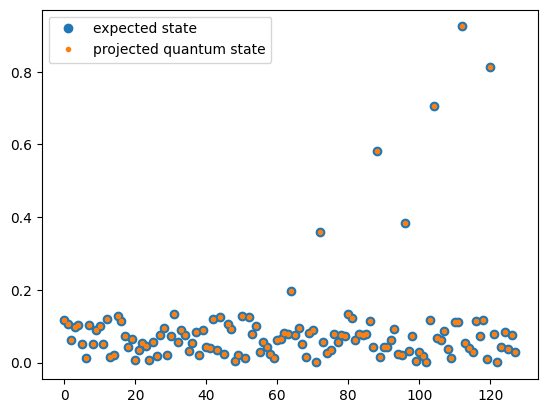

In [27]:
import matplotlib.pyplot as plt

plt.plot(np.abs(cl_vector), "o", label="expected state")
plt.plot(np.abs(reduced_sv) * BE_NORM_FACTOR, ".", label="projected quantum state")
plt.legend();

We also compute the norm for the difference between the results

In [30]:
l2_norm = np.linalg.norm(cl_vector - np.array(reduced_sv) * BE_NORM_FACTOR)
print(f"The L2-norm: {l2_norm}")
assert l2_norm < 1e-10

The L2-norm: 1.5013973106103977e-11


## QSVT step

In [22]:
def get_reflect_around_zero(size):
    qc = QuantumCircuit(size)
    qc.x(0)
    qc.h(0)
    qc.mcx(
        control_qubits=[k for k in range(1, size)],
        ctrl_state="0" * (size - 1),
        target_qubit=[0],
    )
    qc.h(0)
    qc.x(0)

    return qc


def apply_projector_controlled_phase(qc, phase, block_reg, aux_reg):
    qc.append(XGate().control(len(block_reg), ctrl_state=0), block_reg[:] + aux_reg[:])
    qc.rz(phase, aux_reg)

    qc.append(XGate().control(len(block_reg), ctrl_state=0), block_reg[:] + aux_reg[:])


def apply_qsvt_step(qc, phase1, phase2, u, data, block, aux, qsvt_aux):

    qc.append(u, data[:] + block[:] + aux[:])
    apply_projector_controlled_phase(qc, phase1, block, qsvt_aux)
    qc.append(u.inverse(), data[:] + block[:] + aux[:])
    apply_projector_controlled_phase(qc, phase2, block, qsvt_aux)

In [23]:
def get_qsvt_circuit():

    data = QuantumRegister(N_X + N_V + 1, "data")
    block = QuantumRegister(8, "block")
    aux = QuantumRegister(2, "aux")
    qsvt_aux = QuantumRegister(1, "qsvt_aux")

    qsvt_cir = QuantumCircuit(data, block, qsvt_aux, aux)

    apply_qsvt_step(
        qsvt_cir,
        0.1,  # dummy angles
        0.2,  # dummy angles
        be_qc,
        data,
        block,
        aux,
        qsvt_aux,
    )

    return qsvt_cir

In [24]:
qc_qsvt = get_qsvt_circuit()

In [31]:
tqc_qsvt = transpile(qc_qsvt, basis_gates=["u", "cx"], optimization_level=3)
print(f"width: {tqc_qsvt.width()}")
print(f"depth: {tqc_qsvt.depth()}")
print(f"cx: {tqc_qsvt.count_ops()['cx']}")

width: 18
depth: 475033
cx: 248500
